In [1]:
# import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly
import warnings
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# import training and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(6500, 20)
(3500, 19)


In [3]:
# first five records of train data
train_data.head()

Customer Id     Artist Name  Artist Reputation  Height  Width  \
0  fffe3900350033003300   Billy Jenkins               0.26    17.0    6.0   
1  fffe3800330031003900     Jean Bryant               0.28     3.0    3.0   
2  fffe3600370035003100    Laura Miller               0.07     8.0    5.0   
3      fffe350031003300  Robert Chaires               0.12     9.0    NaN   
4  fffe3900320038003400    Rosalyn Krol               0.15    17.0    6.0   

   Weight   Material  Price Of Sculpture  Base Shipping Price International  \
0  4128.0      Brass               13.91                16.27           Yes   
1    61.0      Brass                6.83                15.00            No   
2   237.0       Clay                4.96                21.18            No   
3     NaN  Aluminium                5.81                16.31            No   
4   324.0  Aluminium                3.18                11.94           Yes   

  Express Shipment Installation Included Transport Fragile  \
0              Yes                    No   Airways      No   
1               No                    No  Roadways      No   
2               No                    No  Roadways     Yes   
3               No                    No       NaN      No   
4              Yes                   Yes   Airways      No   

  Customer Information Remote Location Scheduled Date Delivery Date  \
0        Working Class              No       06/07/15      06/03/15   
1        Working Class              No       03/06/17      03/05/17   
2        Working Class             Yes       03/09/15      03/08/15   
3              Wealthy             Yes       05/24/15      05/20/15   
4        Working Class              No       12/18/16      12/14/16   

           Customer Location    Cost  
0     New Michelle, OH 50777 -283.29  
1  New Michaelport, WY 12072 -159.96  
2      Bowmanshire, WA 19241 -154.29  
3       East Robyn, KY 86375 -161.16  
4        Aprilside, PA 52793 -159.23

In [4]:
# Column type
id_column = ["Customer Id"]
categorical_column = ["Material","International","Express Shipment","Installation Included","Transport","Fragile","Customer Information","Remote Location"]
numerical_column = ['Artist Reputation', 'Height', 'Width','Weight','Price Of Sculpture', 'Base Shipping Price']
date_time_column = ['Scheduled Date', 'Delivery Date']
target_column = ['Cost']

In [5]:
print("No. of Training data Customer Id Included in Test data customer id: ",len(train_data[train_data["Customer Id"].isin(test_data["Customer Id"] == True)]))

No. of Training data Customer Id Included in Test data customer id:  0


In [6]:
print("No. of Unique Customer Ids in training set:",train_data["Customer Id"].nunique())
print("No. of Unique Customer Ids in test set:",test_data["Customer Id"].nunique())

No. of Unique Customer Ids in training set: 6500
No. of Unique Customer Ids in test set: 3500


In [7]:
# Drop Customer ID
train_data.drop(labels=["Customer Id"], axis=1, inplace=True)
test_data.drop(labels=["Customer Id"], axis=1, inplace=True)

In [8]:
# Combining train and test data
train_data["is_train"] = True
test_data["is_train"] = False

test_data[target_column[0]] = np.nan
combine_data = pd.concat([train_data, test_data])
combine_data.reset_index(drop=True, inplace = True)
print(combine_data.shape)

(10000, 20)


In [9]:
# Null values in Combine dataset
null_values = combine_data.isnull().sum()
pd.DataFrame({"Null Values" : null_values, 
             "Percentage" : ((null_values*100) / len(combine_data))}).sort_values("Null Values", ascending=False).head(8)

Null Values  Percentage
Cost                      3500       35.00
Transport                 1624       16.24
Artist Reputation          972        9.72
Remote Location            771        7.71
Material                   764        7.64
Weight                     736        7.36
Width                      725        7.25
Height                     494        4.94

### Null Values in Transport Column

In [10]:
combine_data["Transport"].value_counts()

Roadways     3366
Airways      3033
Waterways    1977
Name: Transport, dtype: int64

In [11]:
combine_data["Transport"].fillna("Unknown", inplace=True)

### Null Values in Remote Location Column

In [12]:
combine_data["Remote Location"].value_counts()

No     7383
Yes    1846
Name: Remote Location, dtype: int64

In [13]:
combine_data["Remote Location"].fillna("Unknown", inplace=True)

### Null Values in Material Column

In [14]:
combine_data["Material"].value_counts()

Aluminium    1367
Bronze       1363
Brass        1340
Clay         1313
Wood         1307
Marble       1302
Stone        1244
Name: Material, dtype: int64

In [15]:
temp = pd.DataFrame({"Min_Price":combine_data.groupby("Material").min()["Price Of Sculpture"],
             "Max_Price" : combine_data.groupby("Material").max()["Price Of Sculpture"],
              "Median_Price" : combine_data.groupby("Material").median()["Price Of Sculpture"],
              "Mean_Price" : combine_data.groupby("Material").mean()["Price Of Sculpture"]
             }).sort_values("Max_Price")

temp

Min_Price  Max_Price  Median_Price   Mean_Price
Material                                                  
Wood            3.00      25.13         5.080     5.086266
Aluminium       3.00     131.75         5.440     6.664075
Clay            3.00     280.78         6.100    11.758149
Bronze          3.00    1638.98        12.160    45.912421
Brass           3.01    2700.89        19.615    92.973985
Marble          3.00   93376.59       309.855  2540.158791
Stone           3.20  382385.67       525.095  5815.017886

In [16]:
# Filling null values in material column as per maximum Price of Sculpture of that particular material
combine_data["Material"].fillna(inplace=True , value =combine_data["Price Of Sculpture"].apply(lambda x : temp[temp["Max_Price"]>(x-0.001)]["Max_Price"].idxmin()))

In [17]:
combine_data["Material"].value_counts()

Wood         1793
Aluminium    1479
Bronze       1418
Brass        1363
Clay         1356
Marble       1347
Stone        1244
Name: Material, dtype: int64

### Null Values in Artist Reputation Column

In [18]:
combine_data["Artist Reputation"].isnull().sum()

972

In [19]:
# Below is the list of artist Name who have null values and also have more than one record(with null or not null values) in dataset
null_repu_artist_name = combine_data[combine_data["Artist Reputation"].isnull()]["Artist Name"].to_list()
s = combine_data[combine_data["Artist Name"].isin(null_repu_artist_name)]["Artist Name"].value_counts()
s = s[s>1]
s

Robert Davis        4
Michael White       3
James Smith         3
James White         3
Barbara Thomas      2
Walter Patterson    2
Richard Williams    2
David Brown         2
Tracy Anderson      2
Michelle Hu         2
Kathleen Brown      2
William Jones       2
James Jackson       2
Karen Martin        2
Mary Harris         2
John Moody          2
Michael Freeman     2
Nancy Lopez         2
Joseph Moore        2
Joseph Jones        2
John Austin         2
Linda Smith         2
Frank Lopez         2
Mark Jones          2
Mary Smith          2
Charles Williams    2
Mary Todd           2
James Owens         2
Ann Garcia          2
Michael Davis       2
Elizabeth Ross      2
Richard Brown       2
Name: Artist Name, dtype: int64

In [20]:
# Artist Reputation score by taking maximum value of score of those artist who have null values and also have more than one record with given score
dict_1 = dict(combine_data[combine_data["Artist Name"].isin(s.index)].groupby('Artist Name')["Artist Reputation"].max().dropna())
dict_1

{'Ann Garcia': 0.99,
 'Barbara Thomas': 0.36,
 'Charles Williams': 0.57,
 'Elizabeth Ross': 0.1,
 'Frank Lopez': 0.4,
 'James Jackson': 0.08,
 'James Owens': 0.26,
 'James Smith': 0.63,
 'James White': 0.62,
 'John Austin': 0.23,
 'John Moody': 0.65,
 'Joseph Jones': 0.57,
 'Joseph Moore': 0.26,
 'Karen Martin': 0.82,
 'Kathleen Brown': 0.4,
 'Linda Smith': 0.5,
 'Mark Jones': 0.87,
 'Mary Harris': 0.66,
 'Mary Todd': 0.64,
 'Michael Davis': 0.56,
 'Michael Freeman': 0.68,
 'Michael White': 0.13,
 'Michelle Hu': 0.56,
 'Nancy Lopez': 0.06,
 'Richard Brown': 0.38,
 'Richard Williams': 0.29,
 'Robert Davis': 0.63,
 'Tracy Anderson': 0.61,
 'Walter Patterson': 0.17}

In [21]:
# Fill NA in Artist Reputation column according to the above given Values
combine_data["Artist Reputation"] = combine_data["Artist Reputation"].fillna(value=combine_data["Artist Name"].apply(lambda x : dict_1.get(x)))

In [22]:
combine_data["Artist Reputation"].isnull().sum()

941

After filling above values we are left with 941 null values in Artist reputation column.

In [23]:
# Fill rest of the null values with Median value of the column
combine_data["Artist Reputation"].fillna(combine_data["Artist Reputation"].median(), inplace=True)

### Fill NA values in Weight, Height and Width according to their median values

In [24]:
combine_data["Weight"].fillna(combine_data["Weight"].median(), inplace=True)
combine_data["Height"].fillna(combine_data["Height"].median(), inplace=True)
combine_data["Width"].fillna(combine_data["Width"].median(), inplace=True)

In [25]:
train_df = combine_data[combine_data["is_train"] == True]
test_df = combine_data[combine_data["is_train"] == False]

train_df.drop(["is_train"], axis=1, inplace =True)
test_df.drop(["is_train","Cost"], axis=1, inplace = True)
print(train_df.shape)
print(test_df.shape)

(6500, 19)
(3500, 18)


## Categorical Column

In [26]:
for i in np.arange(len(categorical_column)):
    print("Unique Value in Column {} is {} ".format(categorical_column[i],train_df[categorical_column[i]].unique()))

Unique Value in Column Material is ['Brass' 'Clay' 'Aluminium' 'Wood' 'Marble' 'Bronze' 'Stone'] 
Unique Value in Column International is ['Yes' 'No'] 
Unique Value in Column Express Shipment is ['Yes' 'No'] 
Unique Value in Column Installation Included is ['No' 'Yes'] 
Unique Value in Column Transport is ['Airways' 'Roadways' 'Unknown' 'Waterways'] 
Unique Value in Column Fragile is ['No' 'Yes'] 
Unique Value in Column Customer Information is ['Working Class' 'Wealthy'] 
Unique Value in Column Remote Location is ['No' 'Yes' 'Unknown'] 


In [27]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2,subplot_titles=["Ditribution of Various Material", "Distribution of way of Transport"])
material = train_df["Material"].value_counts()
transport = train_df["Transport"].value_counts()
fig.add_trace(
    go.Bar(x = material.index , y= material.values,showlegend=False, marker= dict(color =material.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = transport.index, y= transport.values,showlegend=False, marker= dict(color =transport.values)), row=1, col=2
)
fig['layout']['xaxis']['title'] = "Material"
fig['layout']['xaxis2']['title'] = 'Transport'
fig['layout']['yaxis']['title'] = 'Count'
fig['layout']['yaxis2']['title'] = 'Count'
fig.show()

In [28]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["International Shipment","Express Shipment","Installation Included"],
                   shared_yaxes=False)
temp_1 = train_df["International"].value_counts()
temp_2 = train_df["Express Shipment"].value_counts()
temp_3 = train_df["Installation Included"].value_counts()
fig.add_trace(
    go.Bar(x = temp_1.index, y= temp_1.values,showlegend=False ,marker = dict(color = temp_1.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = temp_2.index, y= temp_2.values,showlegend=False, marker = dict(color = temp_2.values)), row =1, col=2
)
fig.add_trace(
    go.Bar(x = temp_3.index, y= temp_3.values,showlegend=False, marker = dict(color = temp_3.values)), row =1, col=3
)
fig['layout']['yaxis']['title'] = "Count"
fig.show()

In [29]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["sculpture Fragile","Customer Information","Remote Location"],
                   shared_yaxes=False)
temp_1 = train_df["Fragile"].value_counts()
temp_2 = train_df["Customer Information"].value_counts()
temp_3 = train_df["Remote Location"].value_counts()
fig.add_trace(
    go.Bar(x = temp_1.index, y= temp_1.values,showlegend=False ,marker = dict(color = temp_1.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = temp_2.index, y= temp_2.values,showlegend=False, marker = dict(color = temp_2.values)), row =1, col=2
)
fig.add_trace(
    go.Bar(x = temp_3.index, y= temp_3.values,showlegend=False, marker = dict(color = temp_3.values)), row =1, col=3
)
fig['layout']['yaxis']['title'] = "Count"
fig.show()

## Numerical Column

In [30]:
train_df.describe()

Artist Reputation  Base Shipping Price          Cost       Height  \
count        6500.000000          6500.000000  6.500000e+03  6500.000000   
mean            0.460388            37.407174  1.713920e+04    21.664308   
std             0.250485            26.873519  2.406579e+05    11.625070   
min             0.000000            10.000000 -8.801727e+05     3.000000   
25%             0.270000            16.700000  1.884400e+02    13.000000   
50%             0.450000            23.505000  3.820650e+02    20.000000   
75%             0.640000            57.905000  1.156115e+03    29.000000   
max             1.000000            99.980000  1.114343e+07    73.000000   

       Price Of Sculpture        Weight        Width  
count          6500.00000  6.500000e+03  6500.000000  
mean           1192.42009  3.647828e+05     9.472308  
std            8819.61675  2.556817e+06     5.188552  
min               3.00000  3.000000e+00     2.000000  
25%               5.23000  5.940000e+02     6.000000  
50%               8.02500  3.032000e+03     8.000000  
75%              89.47000  2.656600e+04    11.000000  
max          382385.67000  1.179279e+08    50.000000

Here the cost is showing Negative values

In [31]:
print("No.of records having cost as negative value", len(train_df[train_df['Cost']<0]))

No.of records having cost as negative value 659


In [32]:
train_df[train_df["Cost"]<0].head().sort_values('Cost')

Artist Name  Artist Reputation  Base Shipping Price    Cost  \
0   Billy Jenkins               0.26                16.27 -283.29   
3  Robert Chaires               0.12                16.31 -161.16   
1     Jean Bryant               0.28                15.00 -159.96   
4    Rosalyn Krol               0.15                11.94 -159.23   
2    Laura Miller               0.07                21.18 -154.29   

  Customer Information          Customer Location Delivery Date  \
0        Working Class     New Michelle, OH 50777      06/03/15   
3              Wealthy       East Robyn, KY 86375      05/20/15   
1        Working Class  New Michaelport, WY 12072      03/05/17   
4        Working Class        Aprilside, PA 52793      12/14/16   
2        Working Class      Bowmanshire, WA 19241      03/08/15   

  Express Shipment Fragile  Height Installation Included International  \
0              Yes      No    17.0                    No           Yes   
3               No      No     9.0                    No            No   
1               No      No     3.0                    No            No   
4              Yes      No    17.0                   Yes           Yes   
2               No     Yes     8.0                    No            No   

    Material  Price Of Sculpture Remote Location Scheduled Date Transport  \
0      Brass               13.91              No       06/07/15   Airways   
3  Aluminium                5.81             Yes       05/24/15   Unknown   
1      Brass                6.83              No       03/06/17  Roadways   
4  Aluminium                3.18              No       12/18/16   Airways   
2       Clay                4.96             Yes       03/09/15  Roadways   

   Weight  Width  
0  4128.0    6.0  
3  3032.0    8.0  
1    61.0    3.0  
4   324.0    6.0  
2   237.0    5.0

In [33]:
train_df["Cost"] = np.abs(train_df["Cost"])
train_df["Cost"] = np.log1p(train_df["Cost"])

In [34]:
train_df.head(100)

Artist Name  Artist Reputation  Base Shipping Price      Cost  \
0    Billy Jenkins               0.26                16.27  5.649995   
1      Jean Bryant               0.28                15.00  5.081156   
2     Laura Miller               0.07                21.18  5.045294   
3   Robert Chaires               0.12                16.31  5.088584   
4     Rosalyn Krol               0.15                11.94  5.076610   
..             ...                ...                  ...       ...   
95  Charles Decker               0.45                34.46  7.666831   
96     Taylor Bodi               0.86                17.02  7.310149   
97  Joseph Forsyth               0.99                21.85  6.442110   
98  Shanna Davison               0.27                29.16  5.821654   
99  Richard Ortega               0.42                23.52  6.316334   

   Customer Information           Customer Location Delivery Date  \
0         Working Class      New Michelle, OH 50777      06/03/15   
1         Working Class   New Michaelport, WY 12072      03/05/17   
2         Working Class       Bowmanshire, WA 19241      03/08/15   
3               Wealthy        East Robyn, KY 86375      05/20/15   
4         Working Class         Aprilside, PA 52793      12/14/16   
..                  ...                         ...           ...   
95        Working Class        Obrienside, MT 61007      04/02/17   
96        Working Class       Lake Rachel, WA 97334      10/07/16   
97        Working Class    Alejandrashire, WI 87220      01/19/18   
98        Working Class  East Abigailstad, MA 42359      01/14/15   
99              Wealthy     Samanthaburgh, WY 19962      04/12/15   

   Express Shipment Fragile  Height Installation Included International  \
0               Yes      No    17.0                    No           Yes   
1                No      No     3.0                    No            No   
2                No     Yes     8.0                    No            No   
3                No      No     9.0                    No            No   
4               Yes      No    17.0                   Yes           Yes   
..              ...     ...     ...                   ...           ...   
95               No      No    35.0                    No            No   
96              Yes      No    14.0                   Yes            No   
97               No      No     8.0                    No            No   
98               No     Yes    37.0                   Yes           Yes   
99               No     Yes    24.0                   Yes           Yes   

     Material  Price Of Sculpture Remote Location Scheduled Date  Transport  \
0       Brass               13.91              No       06/07/15    Airways   
1       Brass                6.83              No       03/06/17   Roadways   
2        Clay                4.96             Yes       03/09/15   Roadways   
3   Aluminium                5.81             Yes       05/24/15    Unknown   
4   Aluminium                3.18              No       12/18/16    Airways   
..        ...                 ...             ...            ...        ...   
95      Brass               88.84              No       03/30/17    Unknown   
96      Brass                8.30             Yes       10/03/16    Unknown   
97  Aluminium                6.92              No       01/17/18  Waterways   
98       Clay               28.53              No       01/10/15  Waterways   
99       Clay               32.42              No       04/11/15    Airways   

    Weight  Width  
0   4128.0    6.0  
1     61.0    3.0  
2    237.0    5.0  
3   3032.0    8.0  
4    324.0    6.0  
..     ...    ...  
95  3032.0   13.0  
96  3694.0    7.0  
97   149.0    8.0  
98  7365.0   16.0  
99  4848.0   17.0  

[100 rows x 19 columns]

In [35]:
train_df["Cost"].isnull().sum()

0

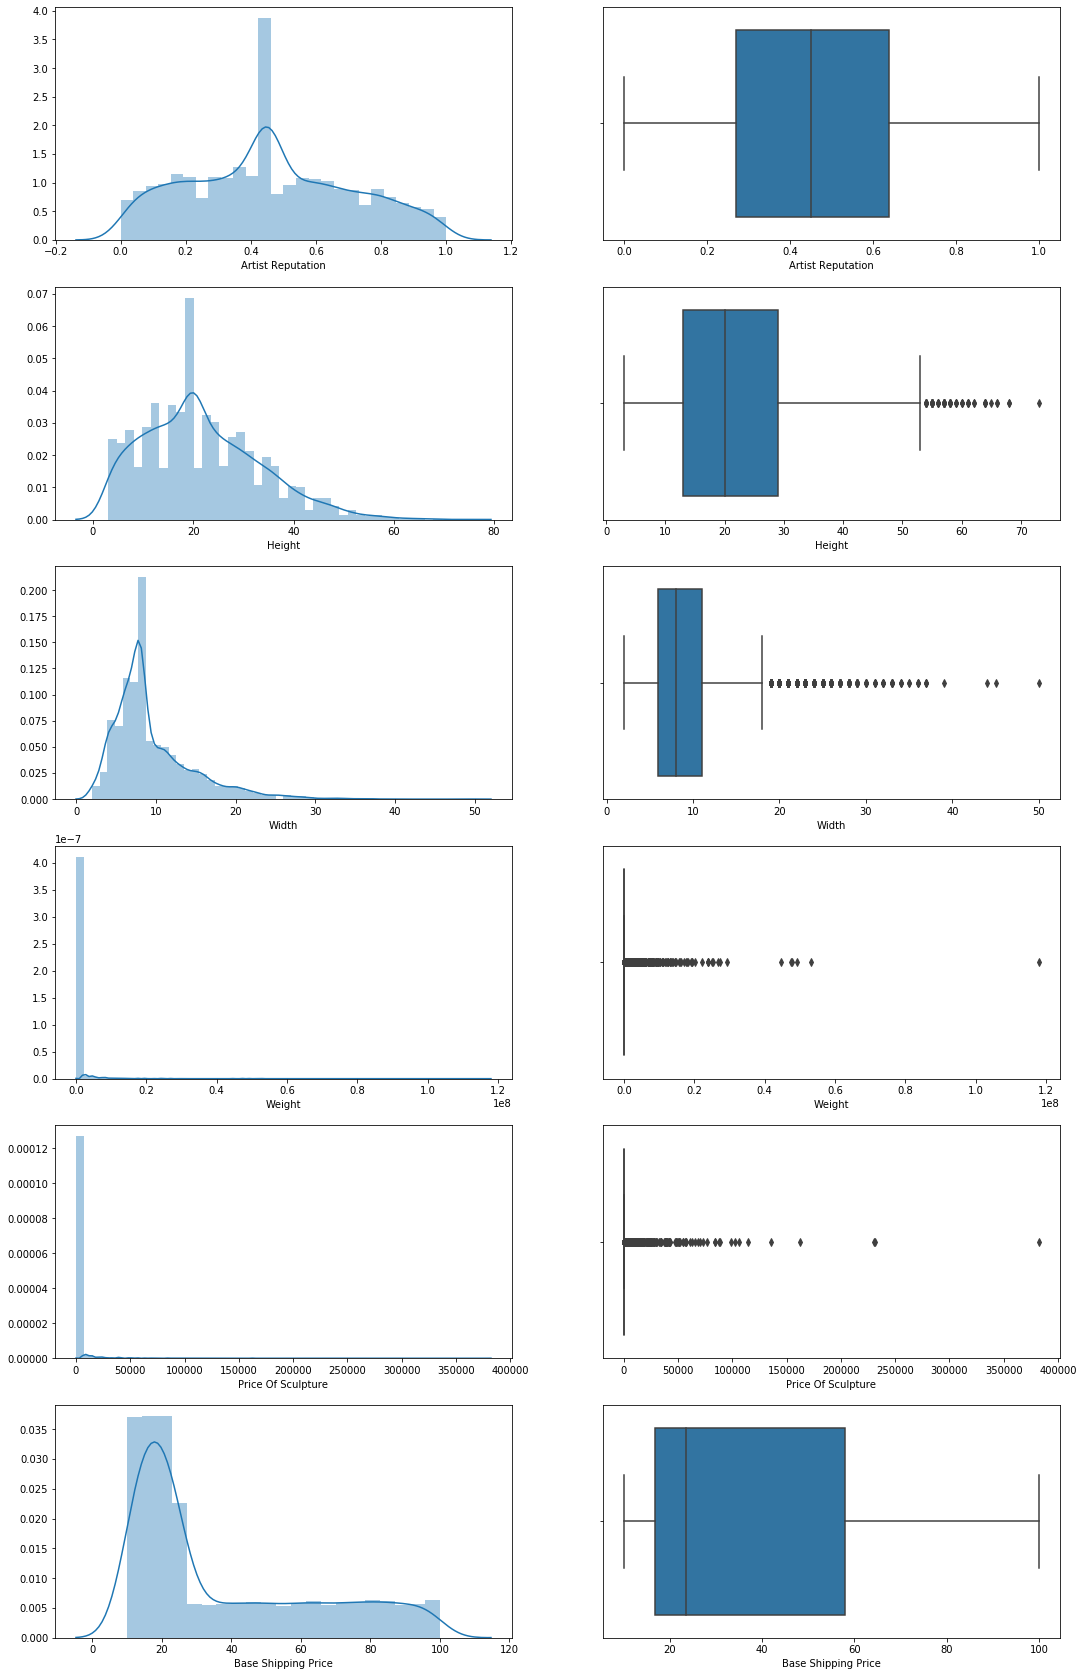

In [36]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize = (18,30))
for i in np.arange(len(numerical_column)):
        sns.distplot(train_df[numerical_column[i]], ax=ax[i][0])
        sns.boxplot(train_df[numerical_column[i]], ax=ax[i][1])
plt.show()

## Remove Outliers

In [37]:
train_df.drop(6133, axis=0, inplace=True)

In [38]:
train_df.shape

(6499, 19)

## Categorical Column Vs Target Column

In [39]:
fig = px.box(data_frame=train_df, x= "Material", y="Cost", color="Material")
fig.update_layout(showlegend= False, title = "Material Wise description of Cost", title_x =0.5)
fig.update_xaxes(categoryorder = "median ascending")
fig.show()

In [40]:
fig = px.box(data_frame=train_df, x = "Transport", y="Cost", color ="Transport")
fig.update_xaxes(categoryorder = "median ascending")
fig.update_layout(title = "Transport Wise description of Cost", showlegend = False, title_x = 0.5)
fig.show()

In [41]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Shipment International wise description of Cost","Express Shipment wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["International"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Express Shipment"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

In [42]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Included Installation wise description of Cost","Sculpture Fragile wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["Installation Included"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Fragile"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

In [43]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Customer Information wise description of Cost","Remote Location wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["Customer Information"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Remote Location"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

## Numerical Column

In [44]:
train_df.corr()

Artist Reputation  Base Shipping Price      Cost  \
Artist Reputation             1.000000            -0.012001  0.324593   
Base Shipping Price          -0.012001             1.000000  0.609900   
Cost                          0.324593             0.609900  1.000000   
Height                       -0.001599             0.342959  0.453449   
Price Of Sculpture            0.046924             0.158795  0.492192   
Weight                        0.009851             0.174755  0.491518   
Width                        -0.009003             0.314578  0.449116   

                       Height  Price Of Sculpture    Weight     Width  
Artist Reputation   -0.001599            0.046924  0.009851 -0.009003  
Base Shipping Price  0.342959            0.158795  0.174755  0.314578  
Cost                 0.453449            0.492192  0.491518  0.449116  
Height               1.000000            0.198859  0.237923  0.706372  
Price Of Sculpture   0.198859            1.000000  0.817900  0.289395  
Weight               0.237923            0.817900  1.000000  0.321190  
Width                0.706372            0.289395  0.321190  1.000000

## Numerical Column Vs Target Column

In [45]:
fig = px.scatter(x = train_df["Artist Reputation"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Artist Reputation and Cost", title_x = 0.5)
fig.update_xaxes(title = "Artist Reputation Score")
fig.update_yaxes(title = "Cost")
fig.show()

In [46]:
fig = px.scatter(x = train_df["Height"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between height and Cost", title_x = 0.5)
fig.update_xaxes(title = "Height")
fig.update_yaxes(title = "Cost")
fig.show()

In [47]:
fig = px.scatter(x = train_df["Width"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Width and Cost", title_x = 0.5)
fig.update_xaxes(title = "Width")
fig.update_yaxes(title = "Cost")
fig.show()

In [48]:
fig = px.scatter(x = train_df["Weight"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Weight and Cost", title_x = 0.5)
fig.update_xaxes(title = "Weight")
fig.update_yaxes(title = "Cost")
fig.show()

In [49]:
fig = px.scatter(x = train_df["Price Of Sculpture"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Price Of Sculpture and Cost", title_x = 0.5)
fig.update_xaxes(title = "Price Of Sculpture")
fig.update_yaxes(title = "Cost")
fig.show()

In [50]:
fig = px.scatter(x = train_df["Base Shipping Price"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Base Shipping Price and Cost", title_x = 0.5)
fig.update_xaxes(title = "Base Shipping Price")
fig.update_yaxes(title = "Cost")
fig.show()

In [51]:
train_df.head()

Artist Name  Artist Reputation  Base Shipping Price      Cost  \
0   Billy Jenkins               0.26                16.27  5.649995   
1     Jean Bryant               0.28                15.00  5.081156   
2    Laura Miller               0.07                21.18  5.045294   
3  Robert Chaires               0.12                16.31  5.088584   
4    Rosalyn Krol               0.15                11.94  5.076610   

  Customer Information          Customer Location Delivery Date  \
0        Working Class     New Michelle, OH 50777      06/03/15   
1        Working Class  New Michaelport, WY 12072      03/05/17   
2        Working Class      Bowmanshire, WA 19241      03/08/15   
3              Wealthy       East Robyn, KY 86375      05/20/15   
4        Working Class        Aprilside, PA 52793      12/14/16   

  Express Shipment Fragile  Height Installation Included International  \
0              Yes      No    17.0                    No           Yes   
1               No      No     3.0                    No            No   
2               No     Yes     8.0                    No            No   
3               No      No     9.0                    No            No   
4              Yes      No    17.0                   Yes           Yes   

    Material  Price Of Sculpture Remote Location Scheduled Date Transport  \
0      Brass               13.91              No       06/07/15   Airways   
1      Brass                6.83              No       03/06/17  Roadways   
2       Clay                4.96             Yes       03/09/15  Roadways   
3  Aluminium                5.81             Yes       05/24/15   Unknown   
4  Aluminium                3.18              No       12/18/16   Airways   

   Weight  Width  
0  4128.0    6.0  
1    61.0    3.0  
2   237.0    5.0  
3  3032.0    8.0  
4   324.0    6.0

In [52]:
# Date and time Column
train_df["Scheduled Date"] = pd.to_datetime(train_df["Scheduled Date"])
train_df["Delivery Date"] = pd.to_datetime(train_df["Delivery Date"])

train_df["days"] = (train_df["Delivery Date"] - train_df["Scheduled Date"]).dt.days
train_df["month"] =train_df["Delivery Date"].dt.month 
train_df["year"] = train_df["Delivery Date"].dt.year
train_df["day_of_week"] = train_df["Delivery Date"].dt.dayofweek


test_df["Scheduled Date"] = pd.to_datetime(test_df["Scheduled Date"])
test_df["Delivery Date"] = pd.to_datetime(test_df["Delivery Date"])

test_df["days"] = (test_df["Delivery Date"] - test_df["Scheduled Date"]).dt.days
test_df["month"] =test_df["Delivery Date"].dt.month 
test_df["year"] = test_df["Delivery Date"].dt.year
test_df["day_of_week"] = test_df["Delivery Date"].dt.dayofweek


In [53]:
# Drop Name , Address and Date and Time Column
train_df.drop(labels=["Artist Name","Customer Location","Delivery Date","Scheduled Date"], axis=1, inplace=True)
test_df.drop(labels=["Artist Name","Customer Location","Delivery Date","Scheduled Date"], axis=1, inplace=True)

In [54]:
# Label Encoder for Categorical Column
train_df["International"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Express Shipment"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Installation Included"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Fragile"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Customer Information"].replace({'Working Class':0, 'Wealthy':1}, inplace=True)

test_df["International"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Express Shipment"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Installation Included"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Fragile"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Customer Information"].replace({'Working Class':0, 'Wealthy':1},inplace= True)

In [55]:
# Feature Column and Target Column Split
X_train = train_df.drop("Cost", axis=1)
y_train = train_df["Cost"]
X_test = test_df

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6499, 18)
(3500, 18)
(6499,)


### CAT BOOST

In [ ]:
training_accuracy =[]
validation_accuracy = []
y_test_prediction =[]
k_fold = KFold(n_splits=5,shuffle=True, random_state=101)
for fold_index , (train_index, val_index) in enumerate(k_fold.split(X_train)):
    print("K_Fold_Value ", fold_index)
    X_train_ , y_train_ = X_train.iloc[train_index] ,y_train.iloc[train_index]
    X_validation , y_validation = X_train.iloc[val_index], y_train.iloc[val_index]
    
    cat_boost = CatBoostRegressor(learning_rate=0.09, n_estimators=2000, random_state=101,max_depth=5, 
                                  cat_features=['Material','Transport','Remote Location','month','year','day_of_week'],
                                 colsample_bylevel=0.9)
    cat_boost.fit(X_train_,y_train_)
    
    y_train_prediction = cat_boost.predict(X_train_)
    y_validation_prediction = cat_boost.predict(X_validation)
    y_test_prediction.append(cat_boost.predict(X_test))
    
    training_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_train_), np.expm1(y_train_prediction))))
    validation_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_validation), np.expm1(y_validation_prediction))))

y_test_prediction = np.mean(y_test_prediction, axis=0)
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

In [84]:
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

y_test_prediction = np.expm1(y_test_prediction)
test_data = pd.read_csv("test.csv")
sample_submission = pd.DataFrame({"Customer Id":test_data["Customer Id"],
                                "Cost":y_test_prediction })
sample_submission.to_csv("sample_submission.csv", index= False)

Accuracy on training Set  97.7698313663404
Accuracy on Validation Set 92.00592339682112


**Accuracy on Test Set 95.37 Percent**

## XGBoost

In [79]:
X_train_1 = pd.get_dummies(X_train, columns=['Material','Transport','Remote Location','month','year','day_of_week']) 
X_test_1 = pd.get_dummies(X_test, columns = ['Material','Transport','Remote Location','month','year','day_of_week'])

print(X_train_1.columns.difference(X_test_1.columns)[0])
print(X_test_1.columns.difference(X_train_1.columns)[0])

Remote Location_Unknown
year_2014


In [80]:
# Drop columns from training data which is not in test data and drop column from test data which is not in training data.
X_train_1.drop("Remote Location_Unknown", axis=1, inplace=True)
X_test_1.drop("year_2014", axis=1, inplace=True)

In [85]:
from xgboost import XGBRegressor

training_accuracy =[]
validation_accuracy = []
y_test_prediction =[]
k_fold = KFold(n_splits=5,shuffle=True, random_state=101)
for fold_index , (train_index, val_index) in enumerate(k_fold.split(X_train_1)):
    print("K_Fold_Value ", fold_index)
    X_train_ , y_train_ = X_train_1.iloc[train_index] ,y_train.iloc[train_index]
    X_validation , y_validation = X_train_1.iloc[val_index], y_train.iloc[val_index]
    
    XGB_regressor = XGBRegressor(learning_rate=0.05, n_estimators=2000, random_state=101,max_depth=5, colsample_bytree=0.9,
                                colsample_bylevel=1,colsample_bynode=1)
    XGB_regressor.fit(X_train_,y_train_)
    
    y_train_prediction = XGB_regressor.predict(X_train_)
    y_validation_prediction = XGB_regressor.predict(X_validation)
    y_test_prediction.append(XGB_regressor.predict(X_test_1))
    
    training_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_train_), np.expm1(y_train_prediction))))
    validation_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_validation), np.expm1(y_validation_prediction))))

y_test_prediction = np.mean(y_test_prediction, axis=0)
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

K_Fold_Value  0
K_Fold_Value  1
K_Fold_Value  2
K_Fold_Value  3
K_Fold_Value  4
Accuracy on training Set  99.75323107851106
Accuracy on Validation Set 92.35671049558692


In [86]:
y_test_prediction = np.expm1(y_test_prediction)
test_data = pd.read_csv("test.csv")
sample_submission = pd.DataFrame({"Customer Id":test_data["Customer Id"],
                                "Cost":y_test_prediction })
sample_submission.to_csv("sample_submission.csv", index= False)


**Accuracy on test set 95.10**